In [2]:
import torch
import torchvision.transforms as tvt
from torch.utils.data import DataLoader
from tqdm import tqdm
import shutil
import pandas as pd
import numpy as np
import os
torch.manual_seed(1234)
from evaluate_metrics import compute_eer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

## Voice Phishing

In [13]:
# load in the wild protocol
vp_df = pd.read_csv("/datab/Dataset/intern_2024_jan31/voice_phishing_dataset/protocol.txt", sep=" ", header=None)
vp_df.columns = ['path', 'subset', 'cate', 'label']
vp_df['label'].value_counts()
vp_df.head

# vp_df['utt'] = vp_df['path'].apply(lambda x: x.split('/')[-1].split('.')[0])


<bound method NDFrame.head of                                  path subset cate     label
0     ./금감원_180711/금감원_180711_3_3.wav   eval    -  bonafide
1     ./금감원_180711/금감원_180711_8_3.wav   eval    -  bonafide
2    ./금감원_180711/금감원_180711_16_2.wav   eval    -  bonafide
3     ./금감원_180711/금감원_180711_4_2.wav   eval    -  bonafide
4     ./금감원_180711/금감원_180711_5_1.wav   eval    -  bonafide
..                                ...    ...  ...       ...
453   ./금감원_210513/금감원_210513_1_5.wav   eval    -  bonafide
454   ./금감원_210513/금감원_210513_1_3.wav   eval    -  bonafide
455   ./금감원_210513/금감원_210513_1_4.wav   eval    -  bonafide
456   ./금감원_210513/금감원_210513_1_2.wav   eval    -  bonafide
457   ./금감원_210513/금감원_210513_1_1.wav   eval    -  bonafide

[458 rows x 4 columns]>

### voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt

Accuracy: 76.633166


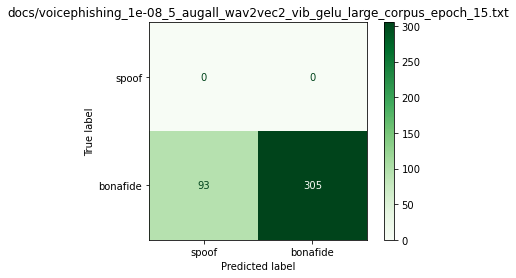

In [20]:
pred_df = pd.read_csv("docs/voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof", "score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['date'] = pred_df['path'].apply(lambda x: x.split('/')[-1].split('_')[-3])
pred_df['date'] = pred_df['path'].apply(lambda x: x.split('/')[1].split('_')[1])
pred_df=pred_df[pred_df['date']<'220101']
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(vp_df, pred_df, on='path')
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt")
print("Accuracy: {:2f}".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [19]:
# pred_df['date'] = pred_df['path'].apply(lambda x: x.split('/')[1].split('_')[1])
pred_df


,path,spoof,score,date,pred
160,./금감원_231006/금감원_보이스피싱_6_2.wav,-8.359336,-0.000234,231006,bonafide
161,./금감원_231006/금감원_보이스피싱_4_5.wav,-0.000248,-8.304127,231006,spoof
162,./금감원_231006/금감원_보이스피싱_12_2.wav,-7.773460,-0.000421,231006,bonafide
163,./금감원_231006/금감원_보이스피싱_9_5.wav,-8.063279,-0.000315,231006,bonafide
164,./금감원_231006/금감원_보이스피싱_11_2.wav,-8.402637,-0.000224,231006,bonafide
165,./금감원_231006/금감원_보이스피싱_6_1.wav,-8.366073,-0.000233,231006,bonafide
166,./금감원_231006/금감원_보이스피싱_2_4.wav,-7.764064,-0.000425,231006,bonafide
167,./금감원_231006/금감원_보이스피싱_12_3.wav,-0.012419,-4.394735,231006,spoof
168,./금감원_231006/금감원_보이스피싱_8_2.wav,-8.381670,-0.000229,231006,bonafide
169,./금감원_231006/금감원_보이스피싱_10_5.wav,-8.381545,-0.000229,231006,bonafide


### voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_acmccs_apr3_more_ko_telephone_epoch_22.txt

Accuracy: 47.598253


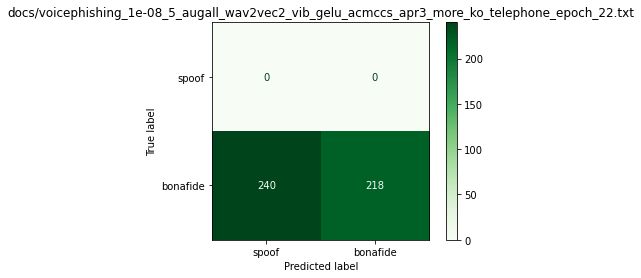

In [17]:
pred_df = pd.read_csv("docs/voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_acmccs_apr3_more_ko_telephone_epoch_22.txt", sep=" ", header=None)
pred_df.columns = ["path", "spoof", "score"]
# pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)
# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(vp_df, pred_df, on='path')
# print(res_df.head)
# compute EER
# spoof_scores = res_df[res_df['label'] == 'spoof']['score']
# bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
# eer, threshold = compute_eer(bonafide_scores, spoof_scores)
# print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
# res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/voicephishing_1e-08_5_augall_wav2vec2_vib_gelu_acmccs_apr3_more_ko_telephone_epoch_22.txt")
print("Accuracy: {:2f}".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## InWild

In [2]:
# load in the wild protocol
in_the_wild = pd.read_csv("../traindata/in_the_wild/protocol.txt", sep=" ", header=None)
in_the_wild.columns = ['utt', 'subset', 'label']
in_the_wild['label'].value_counts()
in_the_wild.head


<bound method NDFrame.head of                  utt subset     label
0          wav/1.wav   eval     spoof
1          wav/2.wav   eval     spoof
2          wav/3.wav   eval     spoof
3          wav/4.wav   eval  bonafide
4          wav/5.wav   eval  bonafide
...              ...    ...       ...
31773  wav/31774.wav   eval  bonafide
31774  wav/31775.wav   eval  bonafide
31775  wav/31776.wav   eval  bonafide
31776  wav/31777.wav   eval  bonafide
31777  wav/31778.wav   eval     spoof

[31778 rows x 3 columns]>

### /dataa/phucdt/vocodetect/Supcon-voco/docs/Inwild_aasistssl_acmccs_epoch22.txt

EER: 12.5088%, threshold: 1.9117


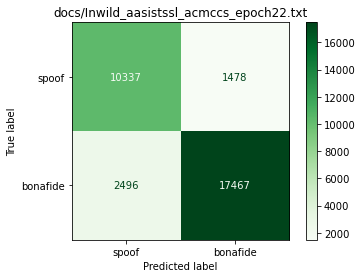

In [5]:
pred_df = pd.read_csv("docs/Inwild_aasistssl_acmccs_epoch22.txt", sep=" ", header=None)
pred_df.columns = ["utt", "spoof","score"]
pred_df['utt'] = pred_df['utt'].apply(lambda x: 'wav/'+x)
# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(in_the_wild, pred_df, on='utt')
# print(res_df.head)
# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("docs/Inwild_aasistssl_acmccs_epoch22.txt")
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

## Intern 2024

In [23]:
intern24_df = pd.read_csv("../traindata/intern_2024/metadata_jan30.csv")
intern24_df.fillna("-", inplace=True)
intern24_df = intern24_df.astype(str)
# print(intern24_df.head)
intern24_df['source_group'] = intern24_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
intern24_df['source_group'] = intern24_df['source_group'].apply(lambda x: 'www.youtube.com' if (x == 'youtu.be' or x == 'youtube.com') else x)

In [63]:
sns2024_df = large_corpus_apr_df[large_corpus_apr_df['group']=='SNS2024']
sns2024_df_utt = large_corpus_apr_df['utt']
intern24_df_utt = intern24_df['utt']
acmccs_apr3_df_utt = acmccs_apr3_df['utt']
# check if there is overlap between SNS2024 and intern2024
overlap = pd.merge(large_corpus_apr_df[large_corpus_apr_df['subset']=='eval'], intern24_df, on='utt')
print(len(overlap))
print(overlap.head)

164
<bound method NDFrame.head of     Utterence name (file name)_x        Speaker name_x   label_x  \
0              Diva_Todwal_6.wav           Diva Todwal  bonafide   
1             Harry_Monroe_7.wav          Harry Monroe  bonafide   
2               Chang_Hwan_2.wav       Park Chang-Hwan  bonafide   
3                     yoon_2.wav        President Yoon  bonafide   
4                    HwaJa_2.wav            Jung HwaJa  bonafide   
..                           ...                   ...       ...   
159               VC_woman_2.wav                 woman     spoof   
160         TTS_Kim_joo_ha_4.wav       Anchor Kimjooha     spoof   
161             VC_Izabela_5.wav               Izabela     spoof   
162   TTS_footballmagazine_2.wav  TTS_footballmagazine     spoof   
163             VC_Izabela_4.wav               Izabela     spoof   

                                  path_x TTS or VC Is multi-speaker?_x  \
0             SNS/2024/Diva_Todwal_6.wav         -                  No   
1

In [61]:
# get meta data for the overlap
print(overlap[overlap['Source link_y'].str.contains("ele")])

Empty DataFrame
Columns: [Utterence name (file name)_x, Speaker name_x, label_x, path_x, TTS or VC, Is multi-speaker?_x, Language_x, Noise type 1_x, Source link_x, utt, group, model, Gender_x, Age_x, subset, Unnamed: 0.1, Model_x, Unnamed: 0, type, Utterence name (file name)_y, Speaker name_y, Is multi-speaker?_y, Language_y, Gender_y, Noise type 1_y, Age_y, Source link_y, label_y, path_y, Model_y, Noise Type, source_group]
Index: []

[0 rows x 32 columns]


In [38]:
sns2024_df['source_group'] = sns2024_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
sns2024_df['source_group'] = sns2024_df['source_group'].apply(lambda x: 'www.youtube.com' if (x == 'youtu.be' or x == 'youtube.com') else x)
sns2024_df['source_group'].value_counts()

/tmp/ipykernel_3011397/2074851656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sns2024_df['source_group'] = sns2024_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
/tmp/ipykernel_3011397/2074851656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sns2024_df['source_group'] = sns2024_df['source_group'].apply(lambda x: 'www.youtube.com' if (x == 'youtu.be' or x == 'youtube.com') else x)


www.youtube.com     963
www.facebook.com     11
Name: source_group, dtype: int64

In [35]:
# check meta of overlap
overlap_meta = intern24_df[intern24_df['utt'].isin(overlap)]
overlap_meta['source_group'].value_counts()

www.youtube.com     213
elevenlabs.io        11
www.facebook.com     11
Name: source_group, dtype: int64

### intern2024_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt

Mean score, Min score, Max score:  -5.572882977317394 -8.452096939086914 -0.0002074026560876
EER: 2.7132%, threshold: -6.3008
False Positive
www.youtube.com - 7 - 2.1021%
elevenlabs.io - 8 - 4.8780%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
False negative
www.youtube.com - 6 - 1.8018%
elevenlabs.io - 0 - 0.0000%
studio.neiro.ai - 0 - 0.0000%
www.facebook.com - 0 - 0.0000%
app.resemble.ai - 0 - 0.0000%
webapp.dubverse.ai - 0 - 0.0000%
grad-tts.github.io - 0 - 0.0000%
nbviewer.org - 0 - 0.0000%
styletts2.github.io - 0 - 0.0000%
jik876.github.io - 0 - 0.0000%
huggingface.co - 0 - 0.0000%
github.com - 0 - 0.0000%
voice.ai - 0 - 0.0000%
www.kecl.ntt.co.jp - 0 - 0.0000%
Accuracy: 

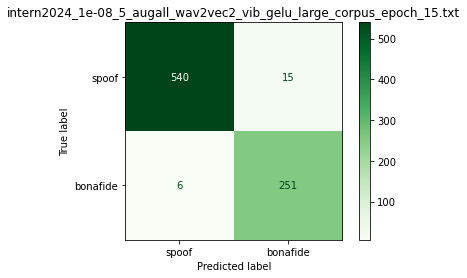

In [4]:
pred_df = pd.read_csv("docs/intern2024_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]

pred_df.drop_duplicates(subset=['utt'], inplace=True)
# supcon_nov22_finetune_df['utt'] = supcon_nov22_finetune_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])
pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# pred_df['pred'] = pred_df['pred'].apply(lambda x: 'bonafide' if x == 1 else 'spoof')
# pred_df['pred'] = pred_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Mean score, Min score, Max score: ", pred_df['score'].mean(), pred_df['score'].min(), pred_df['score'].max())
# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# pred_df.head
# merge eval_df and pred_df on utt
res_df = pd.merge(intern24_df, pred_df, on='utt')
# res_df = res_df[res_df['group'] == 'internOct24']
# filter = res_df[res_df['group']=='inthewild_spoof']
# bona = res_df[res_df['group']=='inthewild_bona']
# bona = res_df[(res_df['label'] == 'bonafide')].sample(n=filter.shape[0], random_state=42)
# res_df = pd.concat([filter, bona])

# compute EER
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')


print("False Positive")
group_name = "source_group"
groups = res_df[group_name].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[group_name]==group)].shape[0]
    num_total = res_df[res_df[group_name]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[group_name]==group)].shape[0]
    num_total = res_df[res_df[group_name]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("intern2024_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [5]:
res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide')]

,utt,Utterence name (file name),Speaker name,Is multi-speaker?,Language,Gender,Noise type 1,Age,Source link,label,path,Model,Noise Type,source_group,spoof,score,pred
262,TTS_Kim_joo_ha_6,TTS_Kim_joo_ha_6.wav,Anchor Kimjooha,-,Korean,Female,-,Adult,https://www.youtube.com/watch?v=nKESsnHxnp8,spoof,./2024_FakeSample/TTS_Sample/TTS_Kim_joo_ha_6.wav,-,Music,www.youtube.com,-0.027881,-3.593721,bonafide
670,VC_staruanko_2,VC_staruanko_2.wav,staruanko,-,Korean,Female,-,Teenager,https://www.youtube.com/shorts/PquGCk2ylYo,spoof,./2024_FakeSample/VC_Sample/VC_staruanko_2.wav,-,Music,www.youtube.com,-3.505112,-0.030504,bonafide
671,VC_staruanko_3,VC_staruanko_3.wav,staruanko,-,Korean,Female,-,Teenager,https://www.youtube.com/shorts/PquGCk2ylYo,spoof,./2024_FakeSample/VC_Sample/VC_staruanko_3.wav,-,Music,www.youtube.com,-3.711048,-0.024756,bonafide
672,VC_staruanko_4,VC_staruanko_4.wav,staruanko,-,Korean,Female,-,Teenager,https://www.youtube.com/shorts/PquGCk2ylYo,spoof,./2024_FakeSample/VC_Sample/VC_staruanko_4.wav,-,Music,www.youtube.com,-6.947346,-0.000962,bonafide
693,VC_shahrukckhan_1,VC_shahrukckhan_1.wav,shahrukckhan,-,Hindi,Male,-,Adult,https://www.youtube.com/watch?v=dR4eijxUubw&t=...,spoof,./2024_FakeSample/VC_Sample/VC_shahrukckhan_1.wav,-,-,www.youtube.com,-8.301609,-0.000248,bonafide
694,VC_shahrukckhan_2,VC_shahrukckhan_2.wav,shahrukckhan,-,Hindi,Male,-,Adult,https://www.youtube.com/watch?v=dR4eijxUubw&t=...,spoof,./2024_FakeSample/VC_Sample/VC_shahrukckhan_2.wav,-,-,www.youtube.com,-8.302061,-0.000248,bonafide
695,VC_shahrukckhan_3,VC_shahrukckhan_3.wav,shahrukckhan,-,Hindi,Male,-,Adult,https://www.youtube.com/watch?v=dR4eijxUubw&t=...,spoof,./2024_FakeSample/VC_Sample/VC_shahrukckhan_3.wav,-,-,www.youtube.com,-3.376859,-0.034751,bonafide
702,VC_Bob_to_son_1,VC_Bob_to_son_1.wav,Seokhee son,-,English,Male,-,Adult,https://elevenlabs.io/speech-synthesis?task=sp...,spoof,./2024_FakeSample/VC_Sample/VC_Bob_to_son_1.wav,-,-,elevenlabs.io,-8.269263,-0.000256,bonafide
703,VC_Bob_to_son_2,VC_Bob_to_son_2.wav,Seokhee son,-,English,Male,-,Adult,https://elevenlabs.io/speech-synthesis?task=sp...,spoof,./2024_FakeSample/VC_Sample/VC_Bob_to_son_2.wav,-,-,elevenlabs.io,-7.774916,-0.000420,bonafide
704,VC_Bob_to_son_3,VC_Bob_to_son_3.wav,Seokhee son,-,English,Male,-,Adult,https://elevenlabs.io/speech-synthesis?task=sp...,spoof,./2024_FakeSample/VC_Sample/VC_Bob_to_son_3.wav,-,-,elevenlabs.io,-8.406527,-0.000223,bonafide


## ACMCCS Apr3

In [26]:
acmccs_apr3_df = pd.read_csv("../traindata/ACMCCS/meta_apr3.csv")
acmccs_apr3_df.fillna("-", inplace=True)
acmccs_apr3_df = acmccs_apr3_df.astype(str)
acmccs_apr3_df['Source link'] = acmccs_apr3_df['Source link'].apply(lambda x: x.replace("youtu.be", "youtube.com").replace("www.youtube.com", "youtube.com"))
# print(supcon_feb07_df.head)
acmccs_apr3_df['type'] = acmccs_apr3_df['Model'].apply(lambda x: "E2E" if "VITS" in x else x)


### acmccs_apr3_1e-08_5_augall_wav2vec2_vib_gelu_supcon_acmccs_apr3_epoch_26.txt

73909
73909
73909
EER: 0.1055%, threshold: -0.0019
Max, Min score:  -0.0007096394547261 -7.607730865478516
False Positive
AIHUB - 6 - 0.0279%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 12 - 0.3659%
SeamlessM4T-TTS - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
Tortoise-TTS - 2 - 0.0417%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2024 - 8 - 0.5780%
SNS2023 - 12 - 0.8523%
False negative
AIHUB - 0 - 0.0000%
LibriSpeech - 3 - 0.0226%
VCTK - 13 - 0.1491%
Elevenlabs - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
SNS2024 - 3 - 0.2168%
SNS2023 - 20 - 1.4205%
Accuracy: 9

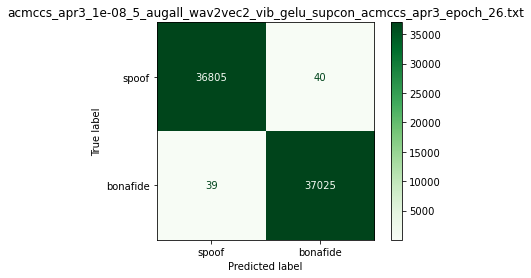

In [7]:
pred_df = pd.read_csv("docs/acmccs_apr3_1e-08_5_augall_wav2vec2_vib_gelu_supcon_acmccs_apr3_epoch_26.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(acmccs_apr3_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("acmccs_apr3_1e-08_5_augall_wav2vec2_vib_gelu_supcon_acmccs_apr3_epoch_26.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [9]:
res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df['group']=='SNS2024')]

,Unnamed: 0.1,path,Utterence name (file name),TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,group,...,Gender,Age,label,Model,subset,Unnamed: 0,type,spoof,score,pred
72199,90400,SNS/2024/VC_shahrukckhan_1.wav,VC_shahrukckhan_1.wav,-,-,Hindi,-,https://youtube.com/watch?v=dR4eijxUubw&t=781s,VC_shahrukckhan_1,SNS2024,...,Male,Adult,spoof,-,eval,1511.0,-,-6.963834,-0.000946,bonafide
72438,90679,SNS/2024/VC_shahrukckhan_3.wav,VC_shahrukckhan_3.wav,-,-,Hindi,-,https://youtube.com/watch?v=dR4eijxUubw&t=781s,VC_shahrukckhan_3,SNS2024,...,Male,Adult,spoof,-,eval,1790.0,-,-6.755858,-0.001165,bonafide
72664,90937,SNS/2024/VC_shahrukckhan_2.wav,VC_shahrukckhan_2.wav,-,-,Hindi,-,https://youtube.com/watch?v=dR4eijxUubw&t=781s,VC_shahrukckhan_2,SNS2024,...,Male,Adult,spoof,-,eval,2048.0,-,-6.913900,-0.000994,bonafide
72814,91118,SNS/2024/VC_woman_1.wav,VC_woman_1.wav,-,-,English,-,https://youtube.com/watch?v=G1tHLs-UK90,VC_woman_1,SNS2024,...,Female,Adult,spoof,-,eval,2229.0,-,-6.965717,-0.000944,bonafide
72964,91293,SNS/2024/VC_shahrukckhan_5.wav,VC_shahrukckhan_5.wav,-,-,Hindi,-,https://youtube.com/watch?v=dR4eijxUubw&t=781s,VC_shahrukckhan_5,SNS2024,...,Male,Adult,spoof,-,eval,2404.0,-,-6.841734,-0.001069,bonafide
73002,91336,SNS/2024/VC_woman_5.wav,VC_woman_5.wav,-,-,English,-,https://youtube.com/watch?v=G1tHLs-UK90,VC_woman_5,SNS2024,...,Female,Adult,spoof,-,eval,2447.0,-,-6.716797,-0.001211,bonafide
73727,92176,SNS/2024/TTS_Kim_joo_ha_5.wav,TTS_Kim_joo_ha_5.wav,-,-,Korean,Music,https://youtube.com/watch?v=nKESsnHxnp8,TTS_Kim_joo_ha_5,SNS2024,...,Female,Adult,spoof,-,eval,3290.0,-,-6.349235,-0.001750,bonafide
73796,92252,SNS/2024/TTS_Kim_joo_ha_4.wav,TTS_Kim_joo_ha_4.wav,-,-,Korean,Music,https://youtube.com/watch?v=nKESsnHxnp8,TTS_Kim_joo_ha_4,SNS2024,...,Female,Adult,spoof,-,eval,3366.0,-,-6.362487,-0.001727,bonafide


## Large_corpus Apr

In [15]:
large_corpus_apr_df = pd.read_csv("../traindata/0_large-corpus/meta_apr12.csv")
large_corpus_apr_df.fillna("-", inplace=True)
large_corpus_apr_df = large_corpus_apr_df.astype(str)
large_corpus_apr_df['Source link'] = large_corpus_apr_df['Source link'].apply(lambda x: x.replace("youtu.be", "youtube.com").replace("www.youtube.com", "youtube.com"))
# print(supcon_feb07_df.head)
large_corpus_apr_df['type'] = large_corpus_apr_df['Model'].apply(lambda x: "E2E" if "VITS" in x else x)


/tmp/ipykernel_3011397/1321604341.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  large_corpus_apr_df = pd.read_csv("../traindata/0_large-corpus/meta_apr12.csv")


### large_corpus_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt

59506
59506
59506
EER: 0.0873%, threshold: -0.0003
Max, Min score:  -0.0001983445836231 -8.492898941040039
False Positive
InWild - 18 - 0.3756%
DDDM-VC - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
AIHUB - 0 - 0.0000%
Elevenlabs - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
SNS2023 - 2 - 0.3030%
SNS2024 - 0 - 0.0000%
LibriSpeech - 0 - 0.0000%
VCTK - 0 - 0.0000%
False negative
InWild - 0 - 0.0000%
DDDM-VC - 0 - 0.0000%
VITS-VC - 0 - 0.0000%
AIHUB - 1 - 0.0105%
Elevenlabs - 0 - 0.0000%
Tortoise-TTS - 0 - 0.0000%
MeloTTS - 0 - 0.0000%
VITS-TTS - 0 - 0.0000%
SeamlessM4T-TTS - 0 - 0.0000%
StyleTTS2 - 0 - 0.0000%
Diff-HierVC - 0 - 0.0000%
DiffGAN - 0 - 0.0000%
OpenVoice - 0 - 0.0000%
StarGANv2-VC - 0 - 0.0000%
MMSTTS - 0 - 0.0000%
SNS2023 - 6 - 0.9091%
SNS2024 - 7 - 1.1589%
LibriSpeech - 13 

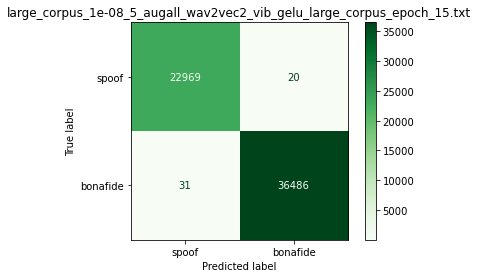

In [69]:
pred_df = pd.read_csv("docs/large_corpus_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt", sep=" ", header=None)
pred_df.columns = ["utt","spoof","score"]
print(len(pred_df))
pred_df = pred_df.drop_duplicates(subset=['utt'])
print(len(pred_df))

pred_df['utt'] = pred_df['utt'].apply(lambda x: x.split('/')[-1].split('.')[0])

# if spoof < score, then bonafide, else spoof
pred_df['pred'] = pred_df.apply(lambda x: 'bonafide' if x['spoof'] < x['score'] else 'spoof', axis=1)

# merge eval_df and pred_df on utt
res_df = pd.merge(large_corpus_apr_df, pred_df, on='utt')
print(len(res_df))
# res_df = res_df[res_df['group'] == 'intern_2024']
# res_df['source_group'] = res_df.apply(lambda x: x['Source link'].replace("//", "/").split("/")[1], axis=1)
# OR compute EER by finding smallest threshold
spoof_scores = res_df[res_df['label'] == 'spoof']['score']
bonafide_scores = res_df[res_df['label'] == 'bonafide']['score']
eer, threshold = compute_eer(bonafide_scores, spoof_scores)
print("EER: {:.4f}%, threshold: {:.4f}".format(eer*100, threshold))
res_df['pred'] = res_df['score'].apply(lambda x: 'spoof' if x < threshold else 'bonafide')
print("Max, Min score: ", res_df['score'].max(), res_df['score'].min())
print("False Positive")

filter = 'group'
groups = res_df[filter].unique()
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    
print("False negative")
for group in groups:
    num_misclass = res_df[(res_df['label'] == 'bonafide') & (res_df['pred']=='spoof') & (res_df[filter]==group)].shape[0]
    num_total = res_df[res_df[filter]==group].shape[0]
    print("{} - {} - {:.4f}%".format(group, num_misclass, num_misclass/num_total*100))
    

# confusion matrix
cm = confusion_matrix(res_df["label"], res_df["pred"], labels=["spoof","bonafide"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["spoof","bonafide"])
disp.plot(cmap='Greens', values_format='g')
plt.title("large_corpus_1e-08_5_augall_wav2vec2_vib_gelu_large_corpus_epoch_15.txt")
print("Accuracy: {:.4f}%".format(accuracy_score(res_df["label"], res_df["pred"])*100))
# plt.savefig("figs/ori_assl_cm.png", dpi=300)
plt.show()

In [70]:
res_df[(res_df['label'] == 'spoof') & (res_df['pred']=='bonafide') & (res_df['group'].str.contains('SNS'))]

,Utterence name (file name),Speaker name,label,path,TTS or VC,Is multi-speaker?,Language,Noise type 1,Source link,utt,...,Gender,Age,subset,Unnamed: 0.1,Model,Unnamed: 0,type,spoof,score,pred
8418,Morgan_Freeman_Singularity_5.wav,Morgan Freeman,spoof,SNS/2023/Morgan_Freeman_Singularity_5.wav,VC,No,English,Music,https://youtube.com/oxXpB9pSETo?si=qJXmXYz8ZSO...,Morgan_Freeman_Singularity_5,...,Male,Adult,dev,149156.0,-,563.0,-,-8.384110,-0.000228,bonafide
59390,Morgan_Freeman_Singularity_2.wav,Morgan Freeman,spoof,SNS/2023/Morgan_Freeman_Singularity_2.wav,VC,No,English,Music,https://youtube.com/oxXpB9pSETo?si=qJXmXYz8ZSO...,Morgan_Freeman_Singularity_2,...,Male,Adult,eval,72750.0,-,2443.0,-,-8.307013,-0.000247,bonafide
